# Load Forecating Model
This notebook is part of the course **EPE043. Introduction to Data Analytics for Smart Energy Systems.**

The Jupiter Notebook is designed to make simple for the student to acoomplish.

This notebook contains basic **Multiple Linear Regression (MLR)** and **NeuralNetwork (NN) methods** for forecasting the electricity load 24 hours in advance

Modified and enhanced by Francisco Gonzalez-Longatt fglongatt@fglongatt.org

## Import general purpose packages #

# Importing some basic packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
import os
import seaborn as sns
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import specialised packages for Machine Learning (ML) and Neural Networks #

Using scikit-learn as **Machine Learning package**

In [114]:
from sklearn import linear_model

Linear Regression is a machine learning algorithm based on supervised learning. 
It performs a regression task. Regression models a target prediction value based on independent variables. 
It is mostly used for finding out the relationship between variables and forecasting. 

Using Keras as package for **Neural Networks (NN)**

In [115]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [116]:
# pd.date_range(start='1/1/2013', end='1/1/2014', freq='H')[0:]

## Load the data in the Notebook 
* Create a folder called **'My_PROJECT'**, it must be the same folder where the notebook is located. Otherwise you will get an error.
* Two datasets are needed:
* **demoData.csv:** Electricity load demand data from 01-01-2013 to 01-01-2014
* **TimeCharacteristic.csv:** 24-h (30 mins resolution) temperature

In [117]:
householdData = pd.read_csv('./demoData.csv', sep=',', index_col=0, header='infer')

Student must replace demoData.csv with your data 
Change the index into datetime format

In [118]:
householdData.index = pd.to_datetime(householdData.index)

Preview the data set

In [119]:
householdData.head()

,MAC004824_Std_F_Comfortable,MAC003676_Std_Q_Adversity,MAC000889_Std_Q_Adversity,MAC003332_Std_G_Comfortable,MAC002790_Std_E_Affluent,MAC003495_Std_H_Comfortable,MAC002969_Std_Q_Adversity,MAC002912_Std_H_Comfortable,MAC004694_Std_E_Affluent,MAC004938_Std_E_Affluent,...,MAC000169_Std_E_Affluent,MAC002750_Std_E_Affluent,MAC003956_Std_E_Affluent,MAC004494_Std_H_Comfortable,MAC003283_Std_C_Affluent,MAC004368_Std_F_Comfortable,MAC002889_Std_H_Comfortable,MAC004963_Std_E_Affluent,MAC001257_Std_Q_Adversity,MAC004194_Std_E_Affluent
2013-01-01 01:00:00,0.127,1.855,0.061,1.216,0.132,0.173,0.352,1.554,0.091,0.160,...,0.259,0.053,0.314,0.533,2.006,0.533,0.162,0.110,0.063,0.211
2013-01-01 02:00:00,0.177,1.437,0.060,0.707,0.132,0.171,0.440,0.717,0.092,0.179,...,0.234,0.095,0.073,0.173,1.173,0.244,0.290,0.095,0.028,0.095
2013-01-01 03:00:00,0.147,1.077,0.055,0.452,0.144,0.158,0.140,0.380,0.327,0.304,...,0.234,0.081,0.096,0.209,1.199,0.233,0.115,0.111,0.047,0.151
2013-01-01 04:00:00,0.133,1.065,0.061,0.351,0.142,0.167,0.128,0.364,0.067,0.065,...,0.244,0.055,0.064,0.264,0.977,0.234,0.098,0.100,0.051,0.111
2013-01-01 05:00:00,0.131,0.859,1.455,0.194,0.205,0.170,0.123,0.320,0.066,0.074,...,0.230,0.059,0.088,0.187,0.526,0.239,0.106,0.099,0.022,0.091


To forecast the aggregate load, it is needed to sum the load for all the households in the demand dataset

In [120]:
loadData = householdData.sum(1)

Change the aggregate load from a series to a dataframe for convenience

In [121]:
loadData = pd.DataFrame(loadData, columns=['Load'])
loadData.index.names = ['time']
# preview the data
loadData.head()

,Load
time,
2013-01-01 01:00:00,42.961
2013-01-01 02:00:00,31.704
2013-01-01 03:00:00,25.720
2013-01-01 04:00:00,24.079
2013-01-01 05:00:00,24.309


Create a seperate series called ts (timestamp) for plotting

In [122]:
ts = loadData.index

Load the weather data, temperature data in this case.
Tempereature will be used as input of the forecasting model

In [123]:
weatherData = pd.read_csv('./weatherDataLondon.csv', sep=',', header='infer')

In [124]:
weatherData = weatherData.set_index('time')
weatherData.head(n=1)

,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation
time,,,,,,,,,,,,,,,,,
2013-01-01 01:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,9.57,8.71,8.1,0.91,999.5,1.98,3.23,247.0,0.76,0.0,10.003,NaN,NaN


The easiest way to make sure that pandas recognises the index as datetime format

In [125]:
# loadData.index = pd.to_datetime(loadData.index)
weatherData.index = pd.to_datetime(weatherData.index)

In [126]:
temperatureData = weatherData['temperature']

##Train/test split
* In this project, the data set is used to  **train/test**, so in is necesary to split it inyo approximately **80/20**
* Data from January to August 2013 will be used to **train** the model 
* Data of September & October is used to **test** the model

In [127]:
np.where(loadData.index.month==9)[0][0]

5831

Pandas package is used to find the dates and create the traing/testing data
* Start **Training** in the first hour of the year - so the index is 0
* End **training** on the hour ending midnight Sept 1st

In [128]:
endTrainIndex = np.where(loadData.index.month==9)[0][0]+1

The testing data starts at endTrainIndex+1

In [129]:
startTestIndex = endTrainIndex

It ends on the hour ending midnight November 1st

In [130]:
endTestIndex = np.where(loadData.index.month==11)[0][0]+1

# **PART 1:** Basic Machine Learning Regression (MLR) Model

In this project, a very basic MLR model is created for the prediction of the electricity demand load on:
* The load 24 hours previously.
* The load 168 previously
* The forecasted temperature at the hour (*remember, it is asummed that the forecasted temperature is correct*)

Therefore, start with an initial model:

$ \hat{l}_{t} = \beta_{0} + \beta_{1}l_{t-24} + \beta_{2} T_t $ <br>

The use data at a lag of 24 hours is selected for training. 
So therefore the training actually starts after the first day.

We make an array called features with the features we want to include:
* So column 1 is $l_{t-24}$
* So column 2 is $T_{t}$

Our target data is then the load at time $t$, i.e. $l_t$

### Create a features array which the data set is split into the training and testing data
Since the model uses a 24 hour lagged variable - it can not ne used the first 24 hours 


In [131]:
features = np.zeros((endTestIndex-24,2))

The 24-hour lagged load is defined

In [132]:
features[:,0] = loadData.Load[0:endTestIndex-24]

Temperature at time t

In [133]:
features[:,1] = temperatureData[24:endTestIndex]
yData = loadData.Load[24:endTestIndex].values

Now the data ser is split the array features into **training** and **testing**

In [134]:
trainingFeatures = features[0:endTrainIndex-24,:]
testingFeatures = features[endTrainIndex-24:,:]
yDataTrain = yData[0:endTrainIndex-24]
yDataTest = yData[endTrainIndex-24:]

## Defining the machine learning regression (MLR) model
Notice It is not need of a column for $\beta_{0}$ as it specify the model to fit an intercept through the python package.
Let define MLR1

In [135]:
MLR1 = linear_model.LinearRegression(fit_intercept=True)

The commnend line above initialises the model and specifies the options 
It only used fit intercept and keep the rest default

In [136]:
MLR1.fit(trainingFeatures, yDataTrain)

LinearRegression()

In [137]:
# train the model
coefMLR1 = MLR1.coef_

## Testing the Fitter Machine Learning Regresion Model (MLR)
The MLR1 model is used to predict the electrical laod demand

In [138]:
predictedMLR1 = MLR1.predict(testingFeatures)
# the actual load
# yDataTest

## Looking into the data
Loot at the last two weeks of August and the first weeks of September

In [139]:
inspectLoad = loadData['Load'][startTestIndex-336:startTestIndex+336]
MLR12weeksAug = MLR1.predict(trainingFeatures[-336:])

## Plotting a graph for the last two weeks of August and first two weeks September

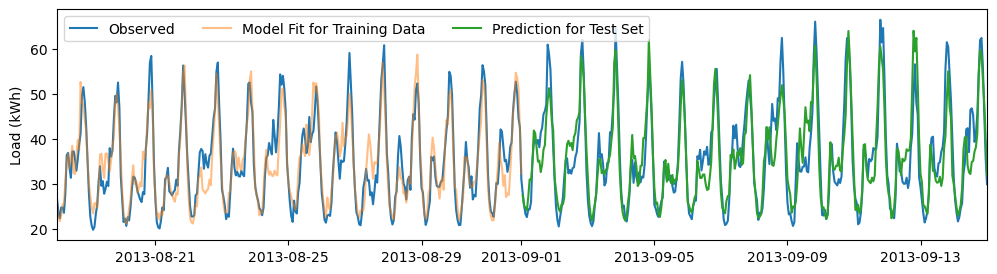

In [140]:
fig = plt.figure()
fig.set_size_inches(12,3)
ax1 = fig.add_subplot(111)
ax1.plot(inspectLoad, label='Observed');
ax1.plot(inspectLoad.index[0:336].to_numpy(), MLR12weeksAug, label='Model Fit for Training Data', alpha=0.5);
ax1.plot(inspectLoad.index[336:].to_numpy(), predictedMLR1[0:336], label='Prediction for Test Set');
ax1.set_xlim([inspectLoad.index[0],inspectLoad.index[-1]])
plt.legend(loc='best', ncol=3);
ax1.set_ylabel('Load (kWh)');

The **Mean absolute percentage error** (MAPE) is used as an error metric: 

$MAPE = \frac{100}{n}\sum_{t=t_1}^{t=t_n} |\frac{\hat{l}_t-l_t}{l_t}$|

Calculating MAPEs

In [141]:
MLR1TrainMAPE = 100*np.mean( np.abs((MLR1.predict(trainingFeatures)-yDataTrain)/yDataTrain) )
MLR1TestMAPE = 100*np.mean( np.abs((predictedMLR1-yDataTest)/yDataTest) )
print('The training MAPE is %.2f'%MLR1TrainMAPE)
print('The testing MAPE is %.2f'%MLR1TestMAPE)

The training MAPE is 9.58
The testing MAPE is 10.20


## **PART 2:** Basic Neural Network Regresion model
* The NN model is defined in **keras**.
* **Sequential model** is defined with a layer-by-layer approach
* The NN is **dense** (as opposed to convolutional) - that is all the nodes are connected to all of the input nodes

**The same features for training the Neural Net as the MLR:**
* So column 1 is $l_{t-24}$
* So column 2 is $T_{t}$

This is not a necessary step!

Any variable can be used as inputs to train the NN (ensuring to stay within the day-ahead constraint - assuming perfect foresight of temperatures)

## Create **Multilayer Perceptron model** (NN1)

In [142]:
NN1 = Sequential()

Defining the **first hidden layer** of the NN:

For the first hidden layer, input_dim must equal the number of inputs at the moment.

It has two inputs:
* **Input 1:** the load at lag 24 
* **Input 2:** the temperature at t

In [143]:
NN1.add(Dense(units=4, input_dim=2, activation='relu'))

Defining the **second hidden layer** 
Fos the second hidden later, it has with 4 nodes

In [144]:
NN1.add(Dense(units=4, activation='relu'))

Defining the **ouput layer**

In [145]:
NN1.add(Dense(units=1))
NN1.compile(loss='mean_squared_error', optimizer='adam')

In [146]:
len(trainingFeatures)

5808

## Fitting the NN model

Using verbose=1 will during the fitting process will print the output to the screen

In [147]:
NN1.fit(trainingFeatures, yDataTrain, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
59/59 [==============================] - 0s 796us/step - loss: 1937.3359
Epoch 2/10
59/59 [==============================] - 0s 785us/step - loss: 1932.4795
Epoch 3/10
59/59 [==============================] - 0s 898us/step - loss: 1927.6355
Epoch 4/10
59/59 [==============================] - 0s 2ms/step - loss: 1922.7906
Epoch 5/10
59/59 [==============================] - 0s 1ms/step - loss: 1917.9753
Epoch 6/10
59/59 [==============================] - 0s 950us/step - loss: 1913.1608
Epoch 7/10
59/59 [==============================] - 0s 813us/step - loss: 1908.3480
Epoch 8/10
59/59 [==============================] - 0s 820us/step - loss: 1903.5496
Epoch 9/10
59/59 [==============================] - 0s 794us/step - loss: 1898.7655
Epoch 10/10
59/59 [==============================] - 0s 794us/step - loss: 1893.9940


## Creating arrays with the predictions for the training and testing set


In [148]:
trainingNN1 = NN1.predict(trainingFeatures)
testingNN1 = NN1.predict(testingFeatures)

46/46 [==============================] - 0s 612us/step


## Looking into the data
Loot at the last two weeks of August and the first weeks of September

In [149]:
NN12weeksAug = trainingNN1[-336:]
NN12weeksSep = testingNN1[0:336]

## Plotting a graph for the last two weeks of August and first two weeks September

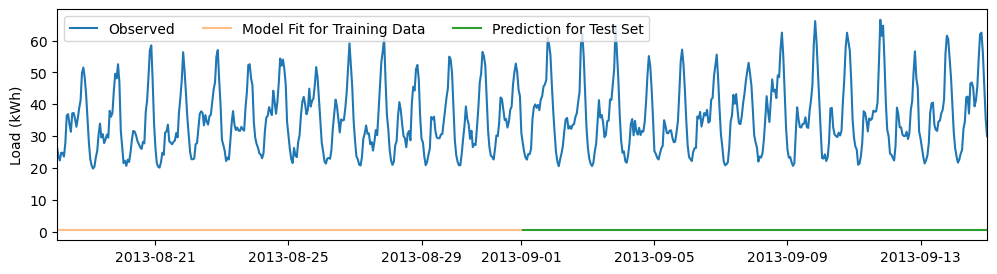

In [150]:
fig = plt.figure()
fig.set_size_inches(12,3)
ax1 = fig.add_subplot(111)
ax1.plot(inspectLoad, label='Observed');
ax1.plot(inspectLoad.index[0:336].to_numpy(), NN12weeksAug, label='Model Fit for Training Data', alpha=0.5);
ax1.plot(inspectLoad.iloc[336:].index.to_numpy(), NN12weeksSep, label='Prediction for Test Set');
ax1.set_xlim([inspectLoad.index[0],inspectLoad.index[-1]])
plt.legend(loc='best', ncol=3);
ax1.set_ylabel('Load (kWh)');

The **Mean absolute percentage error** (MAPE) is used as an error metric: 

$MAPE = \frac{100}{n}\sum_{t=t_1}^{t=t_n} |\frac{\hat{l}_t-l_t}{l_t}$|

Calculating MAPEs

In [151]:
NN1TrainMAPE = 100*np.mean( np.abs((trainingNN1[:,0]-yDataTrain)/yDataTrain) )
NN1TestMAPE = 100*np.mean( np.abs((testingNN1[:,0]-yDataTest)/yDataTest) )
print('The training MAPE is %.2f'%NN1TrainMAPE)
print('The testing MAPE is %.2f'%NN1TestMAPE)

The training MAPE is 98.39
The testing MAPE is 98.32


In [152]:
ts[endTrainIndex]

Timestamp('2013-09-01 01:00:00')

## Plotting the electricity demand load 

Text(0, 0.5, 'Hourly load (kWh per hour)')

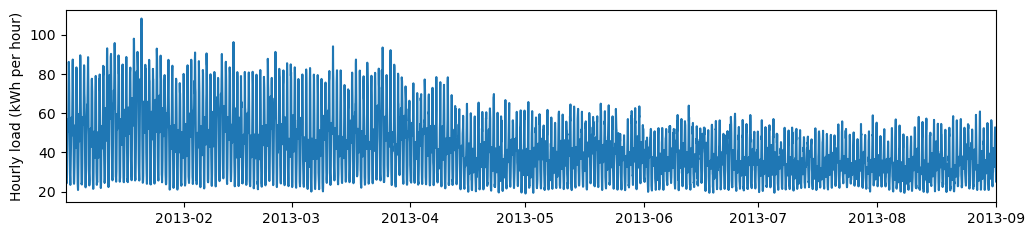

In [153]:
fig = plt.figure(figsize=(12,2.5))
# add a subplot
ax1 = fig.add_subplot(1,1,1) 
ax1.plot(ts, loadData)
ax1.set_xlim([ts[0], ts[endTrainIndex]])
ax1.set_ylabel('Hourly load (kWh per hour)')
# fig.savefig('HourlyLoad.png', dpi=200, format='png', bbox_inches='tight')

## Plotting Temperature versus Load (Data used for training)

Text(0, 0.5, 'Load (kW)')

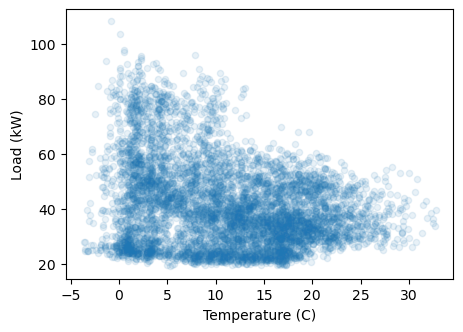

In [154]:
fig = plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
ax1.scatter(trainingFeatures[:,1],trainingFeatures[:,0],marker='o',s=20,alpha=0.1)
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Load (kW)')
# fig.savefig('ScatterExample.png', dpi=200, format='png', bbox_inches='tight')

## Displaying the load data

In [155]:
loadData

,Load
time,
2013-01-01 01:00:00,42.961
2013-01-01 02:00:00,31.704
2013-01-01 03:00:00,25.720
2013-01-01 04:00:00,24.079
2013-01-01 05:00:00,24.309
...,...
2013-12-31 20:00:00,74.124
2013-12-31 21:00:00,67.277
2013-12-31 22:00:00,62.978


## Autocorrelation analysis of the electricity load demand

In [156]:
loadNorm = loadData['Load']-loadData['Load'].mean()
nD = 10 # number of days
lagNWeeks = np.zeros((24*nD))
for j in range(len(lagNWeeks)):
    lagNWeeks[j] = loadNorm.autocorr(lag=j)

## Plotting the Autocorrelation Coefficient 

(-0.2, 1.05)

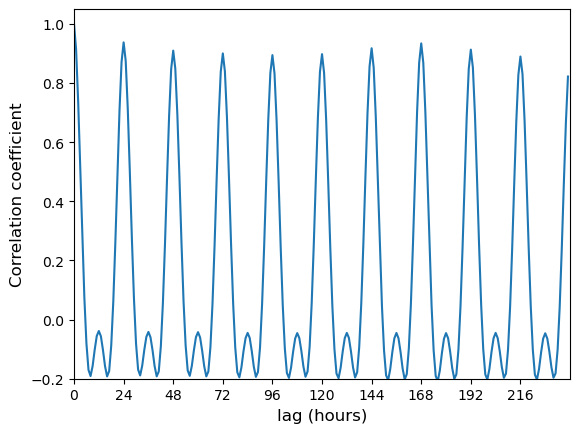

In [157]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
l, = ax1.plot(np.arange(24*nD),lagNWeeks)
ax1.set_xlabel('lag (hours)', fontsize=12)
ax1.set_ylabel('Correlation coefficient', fontsize=12)
ax1.set_xlim([0,24*nD])
ax1.set_xticks(np.arange(0,24*nD,24));
ax1.set_ylim([-0.2,1.05])
# fig.savefig('AutoCorr.png', dpi=200, format='png', bbox_inches='tight')

# Additional code

## Code for saving your NN model
Serialise model to JSON

In [158]:
# # serialize model to JSON
# NN1_json = NN1.to_json()
# with open("NN1.json", "w") as json_file:
#     json_file.write(NN1_json)
# # serialize weights to HDF5
# NN1.save_weights("NN1.h5")
# print("Saved model to disk")

## Load json and create model

In [159]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('NN1.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("NN1.h5")
# print("Loaded model from disk")
# # evaluate loaded model on test data
# loaded_model.compile(loss='mean_squared_error', optimizer='adam')

In [160]:
# testingLoaded = loaded_model.predict(testingFeatures)

In [161]:
# fig = plt.figure()
# fig.set_size_inches(12,3)
# ax1 = fig.add_subplot(111)
# ax1.plot(loadData['Load'][startTestIndex:endTestIndex], label='Observed');
# ax1.plot(loadData['Load'][startTestIndex:endTestIndex].index.to_numpy(), testingLoaded, label='Prediction for Test Set');
# plt.legend(loc='best', ncol=3);
# ax1.set_ylabel('Load (kWh)');